# Getting started with the Data API

### **Let's search & download some imagery of farmland near Stockton, CA. Here are the steps we'll follow:**

1. Define an Area of Interest (AOI)
2. Save our AOI's coordinates to GeoJSON format
3. Create a few search filters
4. Search for imagery using those filters
5. Activate an image for downloading
6. Download an image

### Requirements
- Python 2.7 or 3+
- requests
- A [Planet API Key](https://www.planet.com/account/#/)

## Define an Area of Interest

An **Area of Interest** (or *AOI*) is how we define the geographic "window" out of which we want to get data.

For the Data API, this could be a simple bounding box with four corners, or a more complex shape, as long as the definition is in [GeoJSON](http://geojson.org/) format. 

For this example, let's just use a simple box. To make it easy, I'll use [geojson.io](http://geojson.io/) to quickly draw a shape & generate GeoJSON output for our box:

![geojsonio.png](images/geojsonio.png)

We only need the "geometry" object for our Data API request:

In [1]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl

watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

m = Map(layers=(watercolor, ), center=(50, 354), zoom=5)

draw_control = DrawControl()

draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 1.0
    }
}

m.add_control(draw_control)

m


TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=


In [2]:
# Stockton, CA bounding box (created via geojson.io) 
geojson_geometry = {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -69.63769912719727,
              44.08709182446359
            ],
            [
              -69.57263946533203,
              44.08709182446359
            ],
            [
              -69.57263946533203,
              44.131710111843084
            ],
            [
              -69.63769912719727,
              44.131710111843084
            ],
            [
              -69.63769912719727,
              44.08709182446359
            ]
          ]
        ]
      }



## Create Filters

Now let's set up some **filters** to further constrain our Data API search:

In [3]:
# get images that overlap with our AOI 
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geojson_geometry
}

# get images acquired within a date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": "2015-01-01T00:00:00.000Z",
    "lte": "2019-01-01T00:00:00.000Z"
  }
}

# only get images which have <50% cloud coverage
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": 40,
    "gte": 0
  }
}

# usable_data:
usable_data_filter = {
  "type": "RangeFilter",
  "field_name": "usable_data",
  "config": {
    "gte": .75
  }
}

# combine our geo, date, cloud filters
combined_filter = {
  "type": "AndFilter",
    "config": [geometry_filter, date_range_filter, cloud_cover_filter, usable_data_filter]
    #"config": [geometry_filter, date_range_filter, cloud_cover_filter]
}



# PlanetScope images:
#item_type = ["PSScene3Band"]
#item_type = ["PSScene4Band"]
#item_type = ["PSOrthoTile"]

# RapidEye items:
#item_type = ["REOrthoTile", "REScene"]
#item_type = ["REOrthoTile"]

# SkySat items:
#item_type = ["SkySatCollect", "SkySatScene"]
#item_type = ["SkySatCollect"]

# Landsat:
#item_type = ["Landsat8L1G"]

# Sentinel:
#item_type = ["Sentinel2L1C"]


# Multi:
#item_type = ["REOrthoTile", "REScene", "SkySatCollect"]
#item_type = ["REOrthoTile","Sentinel2L1C"]
#item_type = ["REOrthoTile","Sentinel2L1C","PSScene3Band"]
item_type = ["REOrthoTile","Sentinel2L1C","PSOrthoTile"]
#item_type = ["REOrthoTile", "PSOrthoTile"]





## Searching: Items and Assets

Planet's products are categorized as **items** and **assets**: an item is a single picture taken by a satellite at a certain time. Items have multiple asset types including the image in different formats, along with supporting metadata files.

For this demonstration, let's get a satellite image that is best suited for analytic applications; i.e., a 4-band image with spectral data for Red, Green, Blue and Near-infrared values. To get the image we want, we will specify an item type of `PSScene4Band`, and asset type `analytic`.

You can learn more about item & asset types in Planet's Data API [here](https://planet.com/docs/reference/data-api/items-assets/).

Now let's search for all the items that match our filters:

In [4]:
import os
import json
import time
import types
import requests
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from io import BytesIO
from requests.auth import HTTPBasicAuth

# API Key stored as an env variable
PLANET_API_KEY = os.getenv('PL_API_KEY')
search_api_url = 'https://api.planet.com/data/v1/quick-search?_page_size=10'

#declare global objects to store query results:
df = None
item_props_ex = None


# API request object
search_request = {
  "interval": "day",
  "item_types": item_type, 
  "filter": combined_filter
}


def parse_df(result_json, df=None):
    global item_props_ex
    # first we take the properties object and insert in an array, then insert the higher-level id 
    # and links attributes to each object by reiterating, not very efficient but there should not be many results:
    properties = [ feature['properties'] for feature in result_json['features']]
    for idx, feature in enumerate(result_json['features']):
        properties[idx]['id'] = feature['id']
        properties[idx]['_self'] = feature['_links']['_self']
        properties[idx]['assets'] = feature['_links']['assets']
        properties[idx]['thumbnail'] = feature['_links']['thumbnail']
    # attempt to compress above into one list comp, doesn't work:
    #properties = [ {'id': feature['id']}.update(feature['properties']) for feature in result_json['features']]
    
    #debug: just save a list of properties to print attr name/values later:
    if isinstance(df, types.NoneType):
        item_props_ex = properties[0]
    if df is None:
        df = pd.read_json(json.dumps(properties), convert_dates=['acquired', 'published', 'updated'])
    else:
        df = df.append(pd.read_json(json.dumps(properties), convert_dates=['acquired', 'published', 'updated']), ignore_index=True, verify_integrity=True)
    
    # other approaches that don't work:
    #df = pd.concat([pd.read_json(prop) for prop in properties], ignore_index=True)
    #df = pd.concat([pd.DataFrame.from_dict(prop) for prop in properties])
        
    return df


def search_api(button):
    global df
    button.description = "running..."
    button.button_style = "info"
    with out: print("Querying Planet Search API: {} ".format(search_api_url))
    
    # fire off the POST request
    search_result = \
      requests.post(
        search_api_url,
        auth=HTTPBasicAuth(PLANET_API_KEY, ''),
        json=search_request)

    result_json = search_result.json()
    #print(json.dumps(result_json, indent=2))


    # build up a DataFrame of results, iterating through API _next links until there are no more results:
    i = 1
    df = parse_df(result_json) 
    while result_json['_links']['_next'] is not None:
        #print(result_json['_links']['_next'])
        result_json = \
            requests.get(
                result_json['_links']['_next'],
                auth=HTTPBasicAuth(PLANET_API_KEY, '')).json()

        df = parse_df(result_json, df)
        with out: print("df rowlength: {}".format(df.shape[0]))
        with out: print("result iteration: {}".format(i))
        i = i + 1
    
    with out:
        print("Query completed...")
        print("\nDataFrame columns:")
        display(df.columns)
        print("\nDataFrame info():")
        display(df.info())
        
        print("\nExample item properties:")
        for key, value in item_props_ex.items():
            with out: print("{}: {}".format(key, value))
        
    button.description = "Query Planet API"
    button.button_style = ""
    
    with out2:
        display(df)
        
    

button = widgets.Button(description="Query Planet API", icon="check", tooltip="Run query")
button.on_click(search_api)
#box = widgets.HBox([button, out])
#display(box)
out = widgets.Output()
out2 = widgets.Output()
tab = widgets.Tab()
tab.children = [button, out, out2]
tab.set_title(0, "Query")
tab.set_title(1, "Query Output")
tab.set_title(2, "DataFrame Display")
tab




VGFiKGNoaWxkcmVuPShCdXR0b24oZGVzY3JpcHRpb249dSdRdWVyeSBQbGFuZXQgQVBJJywgaWNvbj11J2NoZWNrJywgc3R5bGU9QnV0dG9uU3R5bGUoKSwgdG9vbHRpcD11J1J1biBxdWVyeSfigKY=


/opt/conda/envs/python2/lib/python2.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Plot Thumbnails, Choose an Item/Asset for Download:

This block includes simple ipywidget controls to filter records in the DataFrame returned from the search by Item type and month of year, and then preview via thumbnail to select individual images to request to activate 'assets' to download.  

Examples of assets include: visual product, analytical product, xml metadata, and others.  For more info, see the API docs: https://developers.planet.com/docs/api/items-assets/

This code uses a few parts of the API, including:

- Get Item details: https://developers.planet.com/docs/api/reference/#operation/GetItem
- List Item assets: https://developers.planet.com/docs/api/reference/#operation/ListItemAssets
- Activate asset: ?documentation?

In [5]:
%matplotlib inline

from ipywidgets import interact, interactive
from IPython.display import display


#workz:
#print(np.sort(df.acquired.dt.year.unique()))
#print(np.sort(df.acquired.dt.month.unique()))

def plot_thumbs(item_type, month):
    global tab
    global get_assets_widget_box
    global get_assets_widget
    
    thumb_urls = df.loc[(df['acquired'].dt.month == month) & (df['item_type'] == item_type), 'thumbnail']
    ids = df.loc[(df['acquired'].dt.month == month) & (df['item_type'] == item_type), 'id']
    
    if (len(ids) > 0):
        thumbs = [ Image.open(BytesIO(requests.get(url, auth=HTTPBasicAuth(PLANET_API_KEY, '')).content)) for url in thumb_urls.values]
        #print(ids.values)

        plt.figure(figsize=(40,20))
        columns = 2
        for i, image in enumerate(thumbs):
            plt.subplot(len(thumbs) / columns + 1, columns, i + 1)
            #plt.title(df.iloc[[i + 1], ['id']], fontsize=20)
            plt.title(ids.values[i], fontsize=20)
            plt.imshow(image)

        metadata = df.loc[(df['acquired'].dt.month == month) & (df['item_type'] == item_type), ['satellite_id', 'acquired', 'id', 'assets']]
        display(metadata)
        #with out: print(metadata)
        
        
        get_assets_widget = interactive(get_assets, id=widgets.Dropdown(
                options=metadata.id,
                value=None,
                description='Get Assets:'
        ))   

        #get_assets_widget_box = widgets.HBox([get_assets_widget])
        get_assets_widget_box.children= [get_assets_widget]
        
        #tab.children.append = get_assets_widget_box
        #tab.children[1] = get_assets_widget_box
        #tab.set_title(1, "Download Assets")    

        
        return metadata
    else:
        if ((item_type != None) & (month != None)):
            print("No assets available for the selected item and month...")
        return None
    
    
    
        
        
    


plot_widget = interactive(plot_thumbs, item_type=widgets.Dropdown(
        options=np.sort(df.item_type.unique()),
        value=None,
        description='Item Type:'
    ),
    month=widgets.Dropdown(
        options=np.sort(df['acquired'].dt.month.unique()),
        value=None,
        description='Month:'
))
#display(plot_widget)




       
def activate_asset(asset):
    if asset is not None:
        print(asset)
    
    # this hits the '_links''activate' URL for the corresponding asset key in assets_json:
    # we need a try/except to catch the None asset passed initially in the Dropdown widget:
    try:
        item_id = get_assets_widget.result[0]
        assets_json = get_assets_widget.result[1]
        #print(json.dumps(assets_json[asset], indent=2))
        
        requests.get(
            assets_json[asset]["_links"]["activate"],
            auth=HTTPBasicAuth(PLANET_API_KEY, '')
          )
        print("Activation req for Item {}, Asset {}: {}".format(item_id, asset, assets_json[asset]["_links"]["activate"]))
        
        print("Download link to try: {}".format(assets_json[asset]["_links"]["_self"]))
        download_link = None
        sleep = 5
        while download_link is None:
            download_link = poll_download_link(assets_json[asset]["_links"]["_self"], sleep)
            if download_link:
                break
            time.sleep(sleep)
            sleep = sleep + 10
            
        print("Download link for item {}, asset {}: {}".format(item_id, asset, download_link))
      
        
    except (TypeError, KeyError):
        pass


# this just checks the activation link to see if available, return download url if so or None if not
def poll_download_link(url, sleep):
    result = \
      requests.get(
        url,
        auth=HTTPBasicAuth(PLANET_API_KEY, '')
      )
    
    status = result.json()["status"]
    #print(json.dumps(result.json(), indent=2))
    
    if "location" in result.json():
        print("Status: {}".format(status))
        return result.json()["location"]
    else:
        print("Status: {}, waiting {} seconds to retry".format(status, sleep))
        return None
    
 
        

def get_assets(id):
    #print(id)
    # assign metadata to the df returned in previous widget:
    metadata = plot_widget.result
    
    # we need a try/except to catch the None passed initially:
    try:
        asset_url = metadata.loc[metadata['id'] == id, 'assets'].values[0]
    except (IndexError, AttributeError):
        return None
    
    # Returns JSON metadata for assets in this ID. Learn more: planet.com/docs/reference/data-api/items-assets/#asset
    result = \
      requests.get(
        asset_url,
        auth=HTTPBasicAuth(PLANET_API_KEY, '')
      )

    assets_json = result.json()
    #print(json.dumps(assets_json, indent=2))

    # we need a list of asset keys to populate the activate_asset_widget (dropdown):
    asset_keys = [key for key in assets_json.keys()]

    # options are the list of asset_key:
    activate_asset_widget = interactive(activate_asset, asset=widgets.Dropdown(
            options=asset_keys,
            value=None,
            description='Activate Asset:'
    )) 

    display(activate_asset_widget)
    
    # return the assets_json to parse later in activate_asset function:
    return id, assets_json


# we need to define the get_assets_widget as a global, bc its instantation is deferred to the
#  plot_thumbs function using results from that function, however its .result attribute also needs to be visible 
#  within the activate_asset function, hence global.  Convoluted but it works...
get_assets_widget = None

# we define a tab widget and create a primary and secondary box and tab, add plot_widget to first, 
#  however defer populating the second ('Download Assets') and create it as an empty box until we have 
#  results from 'Plot Thumbnails' to populate it
plot_widget_box = widgets.HBox([plot_widget])
get_assets_widget_box = widgets.HBox()
children = [plot_widget_box, get_assets_widget_box]
tab = widgets.Tab()
tab.children = children
tab.set_title(0, "Plot Thumbnails")
tab.set_title(1, "Download Assets")


out = widgets.Output()
box = widgets.VBox([tab, out])
display(box)




VkJveChjaGlsZHJlbj0oVGFiKGNoaWxkcmVuPShIQm94KGNoaWxkcmVuPShpbnRlcmFjdGl2ZShjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdJdGVtIFR5cGU6Jywgb3B0aW9ucz3igKY=


## Trial and Error with Matplotlib

Just a few tests of plotting info from the search results DataFrame using Matplotlib.  To be finished.

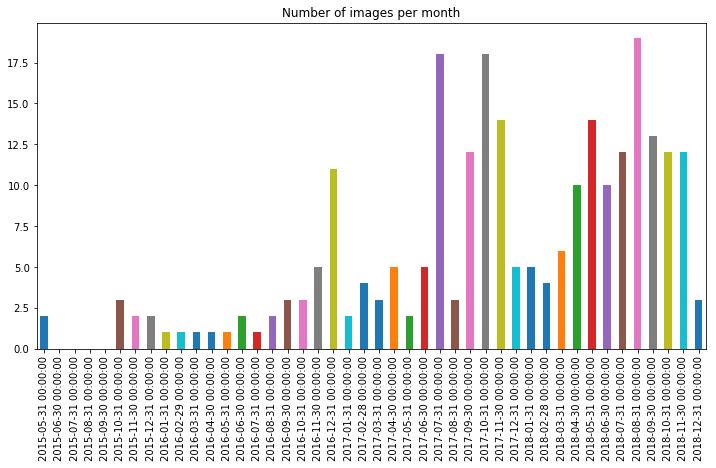

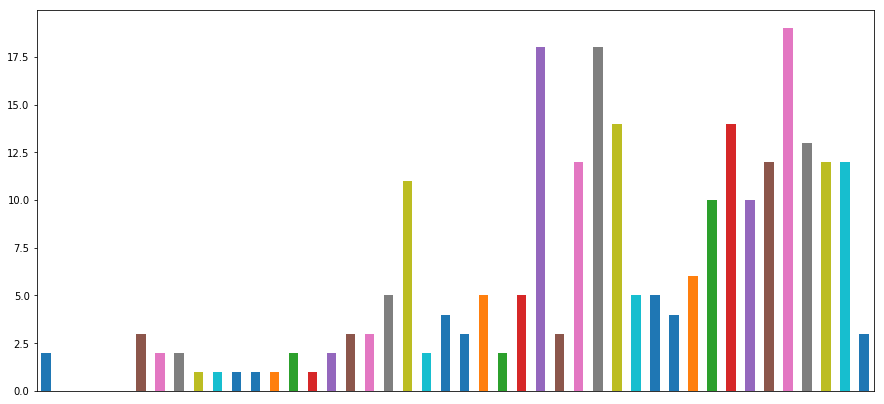

In [6]:
#try to plot the acquired dates:
import matplotlib.dates as mdates
#import matplotlib.axis.Axis as axis



ax = (df['acquired']
    .value_counts()
    .resample('M')
    .sum()
    #.rolling(2).mean()
    .plot(kind='bar',
          #ax=axes.XAxis.set_major_formatter(months),
          figsize=(12, 6),
          title="Number of images per month")
            
    )

#years = mdates.YearLocator()   # every year
#months = mdates.MonthLocator()  # every month
#monthsFmt = mdates.DateFormatter('%M')



'''
ax = (df['acquired']
    .value_counts()
    .resample('M')
    .sum()
    #.rolling(2).mean()
    .plot(kind='bar',
          #ax=axes.XAxis.set_major_formatter(months),
          figsize=(12, 6),
          title="Number of images per month")
            
    )

ax.xaxis_date()
#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
#ax.xaxis_date()

#ax.xaxis.set_major_locator(years)
#ax.xaxis.set_major_formatter(monthsFmt)
#ax.xaxis.set_minor_locator(months)
'''

fig, ax = plt.subplots(figsize=(15,7))
(df['acquired'].value_counts()
    .resample('M')
    .sum().plot(kind='bar',
                ax=ax)
)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


In [ ]:
# just old stuff here:

#print(df.loc[df.acquired.dt.month.unique(), df.acquired.dt.month])
#print(df.loc[df.acquired.dt.month.unique(), ['acquired']])
#print(df.loc[df.acquired.dt.year.unique(), ['acquired']])

#print(df.resample("M", on="acquired")[['acquired']]  )
#print(df.resample("M", on="acquired")[['acquired']].value_counts())


'''
@interact(item_type=widgets.Dropdown(
    options=np.sort(df.item_type.unique()),
    value=np.sort(df.item_type.unique())[0],
    description='Item Type:'
))

# set_itemtype doesn't do anything except return the selected value, but it could:
def set_itemtype(item_type):
    return item_type

item_type = interactive(set_itemtype, item_type=widgets.Dropdown(
    options=np.sort(df.item_type.unique()),
    value=np.sort(df.item_type.unique())[0],
    description='Item Type:'                      
))
display(item_type)

'''

'''
@interact(month=widgets.Dropdown(
    options=np.sort(df['acquired'].dt.month.unique()),
    value=np.sort(df['acquired'].dt.month.unique())[0],
    description='Thumb Preview:'
))


# set_month doesn't do anything except return the selected value, but it could:
def set_month(month):
    return month

month = interactive(set_month, month=widgets.Dropdown(
    options=np.sort(df['acquired'].dt.month.unique()),
    value=np.sort(df['acquired'].dt.month.unique())[0],
    description='Month:'
))
display(month)
'''


![stockton_thumb.png](images/stockton_thumb.png)